# Jupyter Notebook: Action Client UI with Widgets

##  Imports and ROS Initialization

In [1]:
import rospy
import actionlib
from nav_msgs.msg import Odometry
from assignment_2_2024.msg import PlanningAction, PlanningGoal, PlanningFeedback
from assignment_2.msg import RobotFeedback
from std_srvs.srv import Trigger
from actionlib_msgs.msg import GoalStatus
from sensor_msgs.msg import LaserScan

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, clear_output

rospy.init_node("jupyter_action_client", anonymous=True)


##  Interface Class and Widget Setup

In [2]:
class WidgetActionClient:
    def __init__(self):
        self.client = actionlib.SimpleActionClient("/reaching_goal", PlanningAction)
        self.client.wait_for_server()

        self.robot_info = widgets.Label(value="Position: [--, --] | Velocity: [--, --] km/h")
        self.obstacle_label = widgets.Label(value="Distance to closest obstacle: -- m")
        self.goals_reached = 0
        self.goals_cancelled = 0
        self.path_x = []
        self.path_y = []

        rospy.Subscriber("/odom", Odometry, self.odom_callback)
        rospy.Subscriber("/scan", LaserScan, self.laser_callback)
        self.stat_srv = rospy.ServiceProxy("/goal_statistics", Trigger)
        self.info_pub = rospy.Publisher("/robot_information", RobotFeedback, queue_size=10)

    def send_goal(self, x, y):
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = x
        goal.target_pose.pose.position.y = y
        goal.target_pose.pose.orientation.w = 1.0
        self.client.send_goal(goal, done_cb=self.goal_done_cb, feedback_cb=self.feedback_cb)

    def cancel_goal(self, _=None):
        if self.client.get_state() in [GoalStatus.ACTIVE, GoalStatus.PENDING]:
            self.client.cancel_goal()
            rospy.sleep(1.0)

    def goal_done_cb(self, state, result):
        if state == GoalStatus.SUCCEEDED:
            self.goals_reached += 1
        elif state in [GoalStatus.PREEMPTED, GoalStatus.RECALLED]:
            self.goals_cancelled += 1

    def feedback_cb(self, feedback):
        pass  # Optional

    def odom_callback(self, msg):
        x = msg.pose.pose.position.x
        y = msg.pose.pose.position.y
        vx = msg.twist.twist.linear.x * 3.6
        vy = msg.twist.twist.linear.y * 3.6
        self.robot_info.value = f"Position: [{x:.2f}, {y:.2f}] | Velocity: [{vx:.2f}, {vy:.2f}] km/h"

        self.path_x.append(x)
        self.path_y.append(y)

        fb = RobotFeedback(x=x, y=y, vel_x=vx, vel_y=vy, vel_z=msg.twist.twist.angular.z)
        self.info_pub.publish(fb)

    def laser_callback(self, msg):
        min_dist = min([d for d in msg.ranges if d > 0.01])  # Filter invalid values
        self.obstacle_label.value = f"Distance to closest obstacle: {min_dist:.2f} m"


## widget controls

In [3]:
x_input = widgets.FloatText(description="X:")
y_input = widgets.FloatText(description="Y:")
send_btn = widgets.Button(description="Send Goal", button_style='success')
cancel_btn = widgets.Button(description="Cancel", button_style='danger')
stats_btn = widgets.Button(description="Goal Stats", button_style='info')
output = widgets.Output()

client = WidgetActionClient()

send_btn.on_click(lambda _: client.send_goal(x_input.value, y_input.value))
cancel_btn.on_click(client.cancel_goal)
stats_btn.on_click(lambda _: display_goal_stats())

def display_goal_stats():
    with output:
        clear_output()
        try:
            resp = client.stat_srv()
            print(resp.message)
        except rospy.ServiceException as e:
            print(f"Service failed: {e}")

display(widgets.VBox([
    widgets.HBox([x_input, y_input]),
    widgets.HBox([send_btn, cancel_btn, stats_btn]),
    client.robot_info,
    client.obstacle_label,
    output
]))


## Robot position plot

<IPython.core.display.Javascript object>


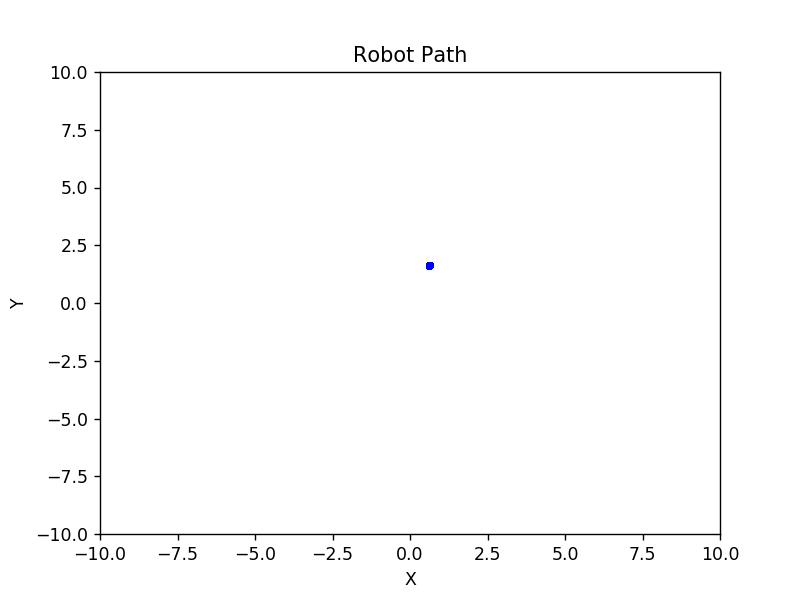

In [4]:
%matplotlib notebook

fig, ax = plt.subplots()
line, = ax.plot([], [], 'b.-')
ax.set_title("Robot Path")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")

def update_path(frame):
    line.set_data(client.path_x, client.path_y)
    return line,

ani = FuncAnimation(fig, update_path, interval=500)


## Goals bar chart

<IPython.core.display.Javascript object>


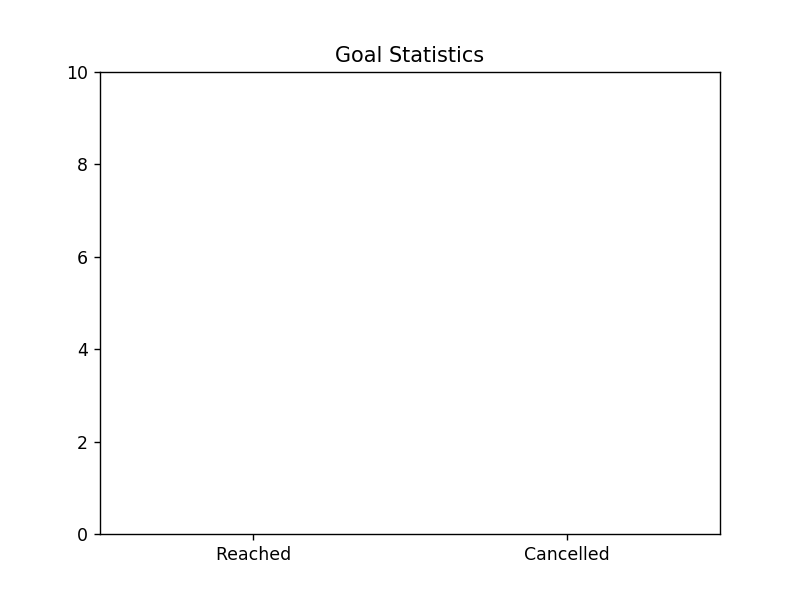

In [5]:
fig2, ax2 = plt.subplots()
bars = ax2.bar(["Reached", "Cancelled"], [0, 0], color=["green", "red"])
ax2.set_ylim(0, 10)
ax2.set_title("Goal Statistics")

def update_stats_plot(frame):
    bars[0].set_height(client.goals_reached)
    bars[1].set_height(client.goals_cancelled)
    return bars

ani2 = FuncAnimation(fig2, update_stats_plot, interval=1000)
